First, load the data,in this notebook we are using the smokoy mountain data as the example, the input data is already the relative abundance matrix. For this analysis, we will do feature selection independently for each response variable.

In [1]:
import sys
sys.path.append('../../../Code')
import loadData 
import RunML
import RunML_continue
import FS
import metric

import pandas as pd
import numpy as np
import random
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import pickle

2025-02-28 13:54:27.598099: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-28 13:54:27.847682: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-28 13:54:27.861841: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740768867.884146 3275444 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740768867.890966 3275444 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-28 13:54:28.153586: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [2]:
data,burn_label,un_label,duration_label,ASVs,df=loadData.loadSoilData("../data/count_table/merge_proportion_asv_smoky_moutain.csv")

In [3]:
df = pd.DataFrame(data,columns = ASVs)# the function requires a dataframe with feature names

In [4]:
print(data.shape)
print(burn_label.shape)

(59, 1768)
(59,)


In [5]:
ASVs = np.array(ASVs)
ASVs

array(['ASV1', 'ASV2', 'ASV3', ..., 'ASV3215', 'ASV3216', 'ASV3217'],
      dtype='<U7')

### 2. Calculating H score for each OTU

Perform feature selection, this is done by calculating Kruskal-Wallis H-test on each OTU for each environmental factor, each OTU/ASV is given a h score.

### 3. Select OTUs

dict_keys(['selected_data', 'selected_columnames', 'selected_indices', 'relative_abundance_data', 'H_score'])

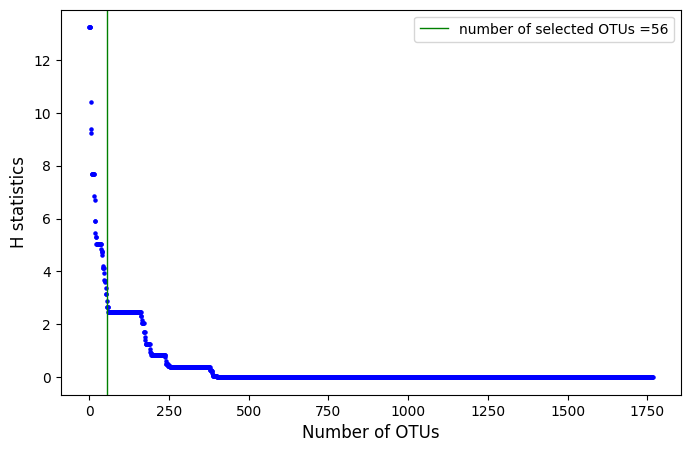

In [6]:
# select the OTUs

selectedresult=FS.SelectMicro_fun(df,burn_label)
    
selectedresult.keys()

In [7]:
selectedOTU_index_list = selectedresult['selected_indices']
selectedASV_list = selectedresult['selected_columnames']
X_FS_list = selectedresult['selected_data']
data = selectedresult['relative_abundance_data']


### 4. Model (default RF or SVM) 
The SVM model is always predicting one class, consider to fine tune the model's parameters.

In [8]:
iter =30
cls = ["RF","SVM", "CatBoost","NB"]

In [9]:

targetLabel=burn_label
print("The response variable and its counts are:")
print(targetLabel.value_counts())

X_FS = X_FS_list

#X_lasso,xlabel_lasso = RunML_continue.LassoFeatureSelection(data,targetLabel)# this is depend on the target variable(do not update here)

X_lasso_ft,xlabel_lasso_ft  = RunML_continue.LassoFS_CV(data,targetLabel)

#X_FS_lasso,xlabel_FS_lasso0 = RunML_continue.LassoFeatureSelection(X_FS,targetLabel)# this is depend on the target variable(do not update here)
#xlabel_FS_lasso = selectedOTU_index_list[xlabel_FS_lasso0]
X_FS_lasso_ft,xlabel_FS_lasso_ft0  = RunML_continue.LassoFS_CV(X_FS,targetLabel)
xlabel_FS_lasso_ft = selectedOTU_index_list[xlabel_FS_lasso_ft0]

xlabel_lasso_FS = np.intersect1d(xlabel_lasso_ft, selectedOTU_index_list)
X_lasso_FS = data[:,xlabel_lasso_FS]

data_subset = {"AllFeatures":data,
               "SelectMicro": X_FS,
               "Lasso_finetune":X_lasso_ft,
               "FS_Lassofinetune":X_FS_lasso_ft,
               "Lassofinetune_FS":X_lasso_FS
               #"Random":data
              }

The response variable and its counts are:
Burn
Yes    42
No     17
Name: count, dtype: int64
Best alpha: 0.1
Best alpha: 0.05


In [10]:
print(f'The shape of the original dataset is ',np.shape(data))
print(f'The shape of the SelectMicro dataset is ',np.shape(X_FS))
print(f'The shape of the Lasso_finetune selected dataset is ',np.shape(X_lasso_ft))
print(f'The shape of the FS_Lasso_finetune selected dataset is ',np.shape(X_FS_lasso_ft))
print(f'The shape of the Lasso_finetune_FS selected dataset is ',np.shape(X_lasso_FS))

The shape of the original dataset is  (59, 1768)
The shape of the SelectMicro dataset is  (59, 56)
The shape of the Lasso_finetune selected dataset is  (59, 14)
The shape of the FS_Lasso_finetune selected dataset is  (59, 15)
The shape of the Lasso_finetune_FS selected dataset is  (59, 14)


In [11]:
print(xlabel_lasso_ft)
print(xlabel_lasso_FS)

[  6   7  62  64  72 108 109 110 154 159 166 224 238 240]
[  6   7  62  64  72 108 109 110 154 159 166 224 238 240]


In [12]:
dict_cm = RunML_continue.runClassifier_FScompare(data_subsets= data_subset,y= targetLabel,classifiers=cls,SMOTE=True)

Classes: ['No' 'Yes']
[1.0, 0.90625, 1.0, 0.8333333333333334, 0.875]
[1.0, 0.84375, 0.8888888888888888, 0.7777777777777779, 0.7083333333333334]


TBB Warning: The number of workers is currently limited to 0. The request for 39 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.



[0.9375, 0.9375, 0.8518518518518519, 0.8333333333333334, 0.875]
[0.75, 0.8125, 0.8333333333333334, 0.9444444444444444, 0.6666666666666667]
[1.0, 1.0, 0.962962962962963, 0.925925925925926, 1.0]
[0.8125, 0.90625, 0.7777777777777778, 1.0, 1.0]
[1.0, 0.96875, 0.925925925925926, 1.0, 0.9166666666666667]
[1.0, 0.8125, 1.0, 0.8888888888888888, 1.0]
[1.0, 1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 0.888888888888889, 1.0, 0.9166666666666667]
[1.0, 1.0, 1.0, 0.9444444444444444, 1.0]
[1.0, 1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 0.962962962962963, 1.0, 0.9166666666666667]
[1.0, 1.0, 1.0, 0.9444444444444444, 1.0]
[1.0, 1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 0.888888888888889, 1.0, 0.9166666666666667]
[1.0, 1.0, 1.0, 0.9444444444444444, 1.0]
                  RF_Accuracy   RF_AUC   RF_Accuracy_std  RF_AUC_std  \
AllFeatures        0.780303    0.922917     0.064639       0.067056    
SelectMicro        0.896970    0.977778     0.039394       0.029630 

In [13]:
print(metric.metric_sum(dict_cm))

                           Accuracy  Precision   Recall   Specification  \
AllFeatures_RF             0.779661  1.000000   0.235294    1.000000      
AllFeatures_SVM            0.745763  0.571429   0.470588    0.857143      
AllFeatures_CatBoost       0.847458  1.000000   0.470588    1.000000      
AllFeatures_NB             0.864407  0.846154   0.647059    0.952381      
SelectMicro_RF             0.898305  1.000000   0.647059    1.000000      
SelectMicro_SVM            0.694915  0.483871   0.882353    0.619048      
SelectMicro_CatBoost       0.881356  1.000000   0.588235    1.000000      
SelectMicro_NB             0.932203  0.842105   0.941176    0.928571      
Lasso_finetune_RF          0.915254  1.000000   0.705882    1.000000      
Lasso_finetune_SVM         0.966102  1.000000   0.882353    1.000000      
Lasso_finetune_CatBoost    0.864407  1.000000   0.529412    1.000000      
Lasso_finetune_NB          0.983051  0.944444   1.000000    0.976190      
FS_Lassofinetune_RF      

In [14]:
dict_cm2 = RunML_continue.runClassifier_FScompare(data_subsets= data_subset,y= targetLabel,classifiers=['xgboost'],SMOTE=True)

Classes: ['No' 'Yes']
[1.0, 0.890625, 0.6296296296296297, 0.8518518518518519, 0.7916666666666667]
[1.0, 0.921875, 0.5925925925925926, 0.9444444444444444, 0.8125]
[1.0, 0.953125, 0.8148148148148149, 0.888888888888889, 0.75]
[1.0, 0.953125, 0.8148148148148149, 0.888888888888889, 0.75]
[1.0, 0.953125, 0.8148148148148149, 0.888888888888889, 0.75]
                  xgboost_Accuracy  xgboost_AUC  xgboost_Accuracy_std  \
AllFeatures           0.828788       0.832755          0.079974         
SelectMicro           0.778788       0.854282          0.069499         
Lasso_finetune        0.793939       0.881366          0.094791         
FS_Lassofinetune      0.793939       0.881366          0.094791         
Lassofinetune_FS      0.793939       0.881366          0.094791         

                  xgboost_AUC_std  xgboost_mcc  xgboost_F  
AllFeatures          0.122174            NaN    0.892329   
SelectMicro          0.144332            NaN    0.856754   
Lasso_finetune       0.090516       

## compare the first 20 index

In [15]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# Keep only the first 20 elements

entries=20

selectedOTU_index_15_list=selectedOTU_index_list[:entries]
selectedASVs20_list = selectedASV_list[:entries]

Validation passed: Dimensions are correct.
Burned= 42, Not Burned = 17
     OTU    presence_pos  presence_neg
0    ASV66    0.000000      0.294118  
1    ASV81    0.000000      0.294118  
2    ASV85    0.000000      0.294118  
3   ASV141    0.000000      0.294118  
4   ASV148    0.000000      0.294118  
5    ASV43    0.000000      0.235294  
6    ASV73    0.023810      0.294118  
7    ASV38    0.047619      0.352941  
8   ASV139    0.000000      0.176471  
9   ASV154    0.000000      0.176471  
10  ASV174    0.000000      0.176471  
11  ASV181    0.000000      0.176471  
12  ASV208    0.000000      0.176471  
13  ASV216    0.000000      0.176471  
14  ASV263    0.000000      0.176471  
15  ASV272    0.000000      0.176471  
16   ASV94    0.023810      0.235294  
17    ASV7    0.452381      0.117647  
18    ASV3    0.285714      0.000000  
19   ASV19    0.285714      0.000000  


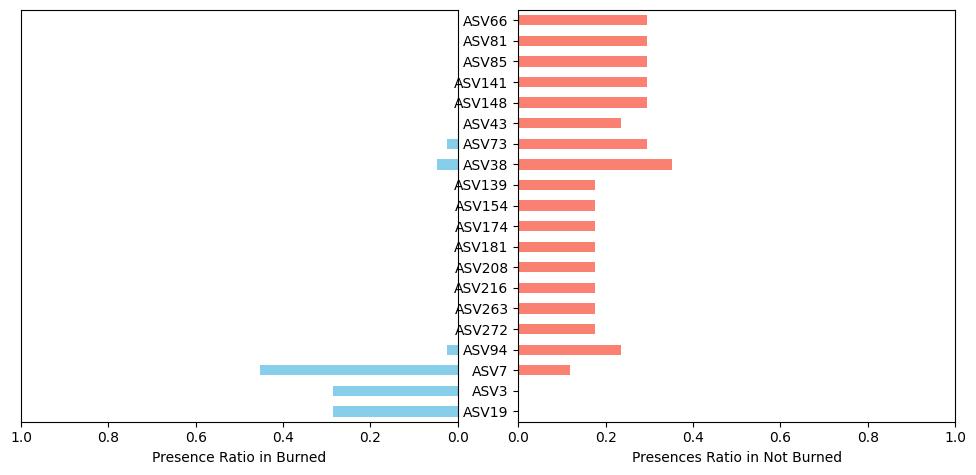

Validation passed: Dimensions are correct.
Burned= 42, Not Burned = 17
     OTU    presence_pos  presence_neg
0     ASV7    0.452381      0.117647  
1     ASV8    0.119048      0.294118  
2    ASV81    0.000000      0.294118  
3    ASV85    0.000000      0.294118  
4    ASV94    0.023810      0.235294  
5   ASV141    0.000000      0.294118  
6   ASV146    0.000000      0.117647  
7   ASV148    0.000000      0.294118  
8   ASV208    0.000000      0.176471  
9   ASV216    0.000000      0.176471  
10  ASV225    0.000000      0.117647  
11  ASV315    0.000000      0.117647  
12  ASV335    0.000000      0.117647  
13  ASV338    0.000000      0.117647  


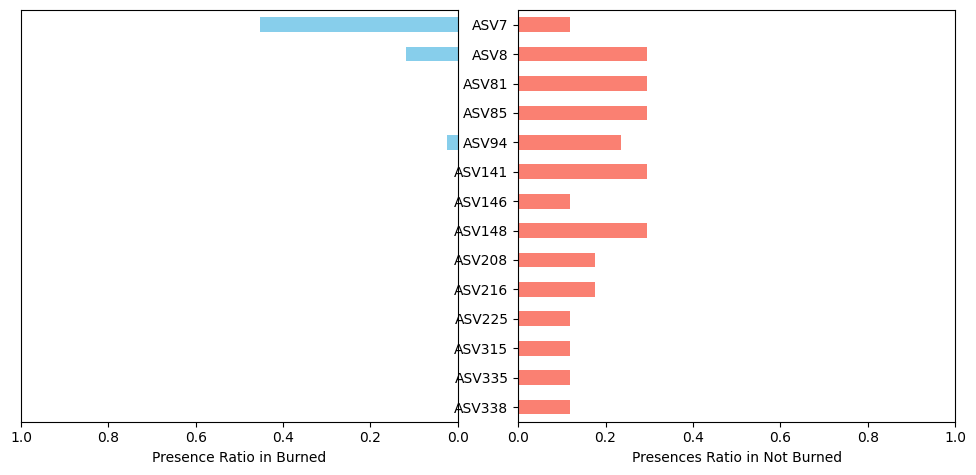

Validation passed: Dimensions are correct.
Burned= 42, Not Burned = 17
     OTU    presence_pos  presence_neg
0    ASV81    0.000000      0.294118  
1    ASV85    0.000000      0.294118  
2   ASV141    0.000000      0.294118  
3   ASV148    0.000000      0.294118  
4   ASV208    0.000000      0.176471  
5   ASV216    0.000000      0.176471  
6    ASV94    0.023810      0.235294  
7     ASV7    0.452381      0.117647  
8   ASV146    0.000000      0.117647  
9   ASV191    0.000000      0.117647  
10  ASV225    0.000000      0.117647  
11  ASV315    0.000000      0.117647  
12  ASV335    0.000000      0.117647  
13  ASV338    0.000000      0.117647  
14    ASV8    0.119048      0.294118  


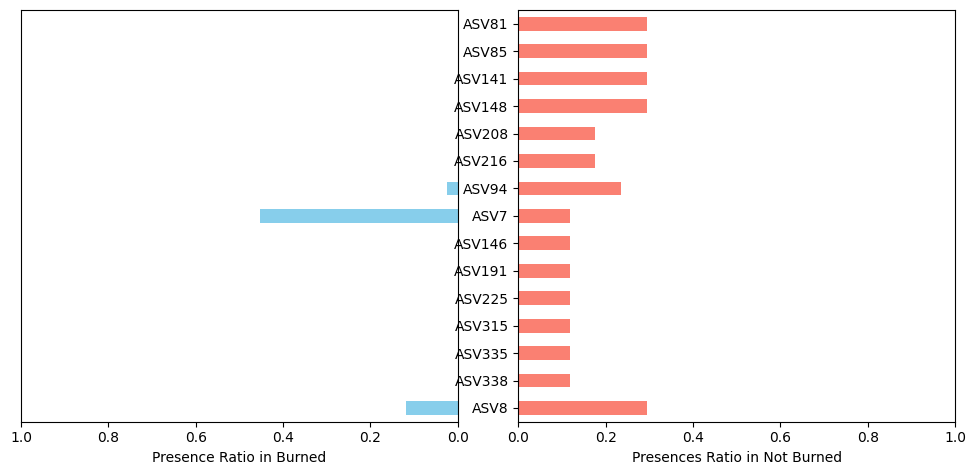

In [16]:
targetLabel=burn_label
FS.plotPresenseRatio(data[:,selectedOTU_index_15_list],targetLabel,selectedASVs20_list,
                     posLabel="Yes",posText="Burned",negText="Not Burned")

FS.plotPresenseRatio(X_lasso_ft,targetLabel,ASVs[xlabel_lasso_ft],
                     posLabel="Yes",posText="Burned",negText="Not Burned")

FS.plotPresenseRatio(X_FS_lasso_ft,targetLabel,ASVs[xlabel_FS_lasso_ft],
                     posLabel="Yes",posText="Burned",negText="Not Burned")